In [2]:
from typing_extensions import Literal
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.types import Command
from langchain_groq import ChatGroq

modlel = ChatGroq(model='llama-3.3-70b-versatile')


@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help."""
    # This tool is not returning anything: we're just using it
    # as a way for LLM to signal that it needs to hand off to another agent
    # (See the paragraph above)
    return


@tool
def transfer_to_addition_expert():
    """Ask addition agent for help."""
    return


def addition_expert(
    state: MessagesState,
) -> Command[Literal["multiplication_expert", "__end__"]]:
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication. "
        "Always do your portion of calculation before the handoff."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    # If there are tool calls, the LLM needs to hand off to another agent
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        # NOTE: it's important to insert a tool message here because LLM providers are expecting
        # all AI messages to be followed by a corresponding tool result message
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )

    # If the expert has an answer, return it directly to the user
    return {"messages": [ai_msg]}


def multiplication_expert(
    state: MessagesState,
) -> Command[Literal["addition_expert", "__end__"]]:
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="addition_expert", update={"messages": [ai_msg, tool_msg]})

    return {"messages": [ai_msg]}

In [3]:
builder = StateGraph(MessagesState)
builder.add_node("addition_expert", addition_expert)
builder.add_node("multiplication_expert", multiplication_expert)
# we'll always start with the addition expert
builder.add_edge(START, "addition_expert")
graph = builder.compile()

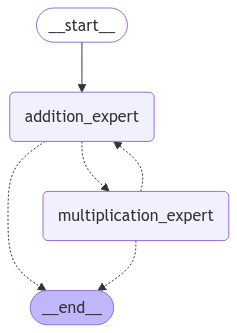

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass